In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from utils import *
from Network import *
from tqdm.autonotebook import tqdm

%matplotlib inline
import matplotlib.pyplot as plt

#hyperparams
enc_seq_len = 6

dim_val = 10
dim_attn = 5
lr = 0.002
epochs = 30

n_heads = 3

n_encoder_layers = 3

batch_size = 15

#init network and optimizer
#                          dim_val, dim_attn, enc_seq_len, input_size, n_encoder_layers = 1, n_heads = 1
t = Transformer_encoder_nn(dim_val, dim_attn, enc_seq_len, 1,          n_encoder_layers,     n_heads)
optimizer = torch.optim.Adam(t.parameters(), lr=lr)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

#keep track of loss for graph
losses = []

In [2]:
def lr_scheduler(d_model, step_num, warmup_steps = 100):
    lr = (d_model**-0.5) * min((step_num**-0.5), step_num * (warmup_steps**-1.5))
    return lr

<ipython-input-3-6c0126e35378>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
epoch : 0/30 loss : 0.010417748242616653 learning rate : 0.0063245553: 100%|██████████| 20/20 [00:00<00:00, 93.30it/s]
epoch : 1/30 loss : 0.010789016261696815 learning rate : 0.0126491106: 100%|██████████| 20/20 [00:00<00:00, 115.26it/s]
epoch : 2/30 loss : 0.0010974028846248984 learning rate : 0.018973666: 100%|██████████| 20/20 [00:00<00:00, 122.93it/s]
epoch : 3/30 loss : 0.003405035240575671 learning rate : 0.0252982213: 100%|██████████| 20/20 [00:00<00:00, 119.90it/s]
epoch : 4/30 loss : 0.0008298035827465355 learning rate : 0.0316227766: 100%|██████████| 20/20 [00:00<00:00, 105.63it/s]
epoch : 5/30 loss : 0.0011828970164060593 learning rate : 0.0288675135: 100%|██████████| 20/20 [00:00<00:00, 105.91it/s]
epoch : 6/30 loss : 0.0004439135664142668 learning rate : 0.0267261242: 100%|██████████| 20/2

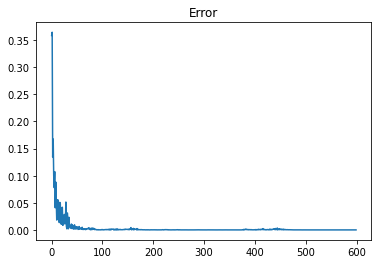

In [3]:
#build live matplotlib fig
fig = plt.figure()

ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

step_num = 0
    
for e in range(epochs):
    out = []
    
    # for scheduler
    # epoch_loss = []

    progress_bar = tqdm(range(-10- enc_seq_len, 10 - enc_seq_len))
    for b in progress_bar:

        step_num += 1
        optimizer.param_groups[0]['lr'] = lr_scheduler(dim_val, step_num)

        optimizer.zero_grad()
        X, Y = get_data(batch_size, enc_seq_len, 1)
        
        # print(X, Y)

        #Forward pass and calculate loss
        net_out = t(X)#.reshape(Y.shape)
        # print(net_out.shape,Y.shape)
        # loss = torch.mean((net_out - Y) ** 2) # MSE
        # loss = torch.sqrt(torch.mean((net_out - Y) ** 2)) # RMSE (paper used this!)
        loss = F.smooth_l1_loss(net_out, Y) # Huber Loss 

        # epoch_loss.append(float(loss))

        #backwards pass
        loss.backward()
        optimizer.step()

        #Track losses and draw rgaph
        out.append([net_out.detach().numpy(), Y])
        losses.append(loss.detach().numpy())

        progress_bar.set_description(f"epoch : {e}/{epochs} loss : {loss.detach().numpy()} learning rate : {round(optimizer.param_groups[0]['lr'],10)}")

    # scheduler.step(np.mean(epoch_loss))

ax.clear()
ax.plot(losses)
ax.set_title("Error")
fig.canvas.draw()



<ipython-input-10-502e6b96200d>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


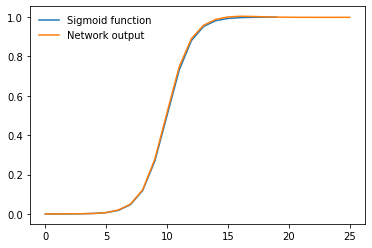

In [10]:
num_range = (-10, 10)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

original = torch.sigmoid(torch.arange(num_range[0],num_range[1]).float()).squeeze(-1).numpy().tolist()
x = torch.sigmoid(torch.arange(num_range[0],num_range[0]+6).float()).squeeze(-1).numpy().tolist()
output = x.copy()

for i in range(num_range[0], num_range[1], 1):
    q = torch.tensor(x).float().reshape(1,6,1)
    out = t(q).detach().squeeze().numpy().tolist()
    
    del x[0]
    x.append(out)
    output.append(out)

ax.clear()
ax.plot(original, label='Sigmoid function')
ax.plot(output, label='Network output')
ax.set_title("")
ax.legend(loc='upper left', frameon=False)